In [2]:
from src.db import Database
from src.score import Score
from src.utils import *
from src.constants import *
import yaml

In [4]:

with open('./conifg.yaml', 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)['experiment']
config
np.random.seed(int(config['model']['seed']))
output_path  = config['database']['data_output_file']

### 1.  Criar banco de dados

In [5]:
database = Database(
    dbname= 'pipo_database.db',
    dbml_path= config['database']['dbml'],
    build = config['database']['build']
)
#database.create_database()

### 2. Simular dados

#### 2.1 Provider

In [7]:
df_provider = make_healt_provider_base_sample(
    config['model']['sample_size'],
    './data/raw/providers/tbEstabelecimento202305.csv'
)
df_provider[~df_provider['provider_name'].isna()].to_csv(f'{output_path}/4_health_provider.csv',index=False)


/Users/jonathaazevedo/Documents/workspace/pipo-test/src/utils.py:80: DtypeWarning: Columns (0,14,15,36,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_providers = pd.read_csv(base_filename,sep=';', encoding='latin-1')


#### 2.2  Specialties and provider specialties

In [19]:

def make_provider_specialties(df_provider, df_specialties,specialties):
    output = pd.DataFrame(columns=['specialty_id','provider_id'])
    data = []
    denormalized = [unidecode(item.replace(' ','_').lower()) for item in specialties]
    for idx, row in df_provider.iterrows():
        
        n = random.randint(1,5) 
        specialties = random.sample(denormalized,n)
        
        out = (
            df_specialties.query("specialty_denormalized_name in @specialties")[['id']]
            .assign(provider_id = row['provider_id'])
            .rename(columns= {'id':'specialty_id'})
        ).to_dict('records')
        data.extend(out)
    output = pd.DataFrame.from_records(data)
    return output



In [20]:
df_specialties = make_specialties_table(SPECIALTIES)
df_provider_specialties = make_provider_specialties(df_provider,df_specialties,SPECIALTIES)

df_specialties.to_csv(f'{output_path}/2_specialties.csv',index=False)
df_provider_specialties.to_csv(f'{output_path}/9_provider_specialties.csv',index=False)

#### 2.3 Certification and provider certifications

In [21]:
certifications = PROVIDER_CERTIFICATION + PROFESSIONAL_CERTIFICATION
df_certifications = make_certification_table(PROVIDER_CERTIFICATION,PROFESSIONAL_CERTIFICATION)
df_provider_certifications = make_provider_certification(df_provider,df_certifications,certifications)


df_certifications.to_csv(f'{output_path}/1_certification.csv',index=False)
df_provider_certifications.to_csv(f'{output_path}/7_provider_certification.csv',index=False)

#### 2.4 Accommodation and provider accommodations

In [22]:
df_accommodation = make_accommodation_table(ACCOMMODATIONS)
df_provider_certifications = make_provider_accommodation(df_provider,df_accommodation,ACCOMMODATIONS)

df_accommodation.to_csv(f'{output_path}/3_accommodation_table.csv',index=False)
df_provider_certifications.to_csv(f'{output_path}/8_provider_accommodation.csv',index=False)


#### 2.5 Providers services costs

In [23]:
df_provider_services_costs = make_provider_service_costs(
    COSTS_DIST,df_provider,df_specialties,df_provider_specialties,9
)
df_provider_services_costs.to_csv(f'{output_path}/5_health_provider_services.csv',index=False)

In [24]:
df_provider_services_costs.groupby('provider_id',as_index = False).agg(n = ('provider_id','count'))['n'].describe()

count    988.000000
mean      13.514170
std        7.421648
min        1.000000
25%        7.000000
50%       13.000000
75%       19.000000
max       37.000000
Name: n, dtype: float64

In [27]:
df_provider_services_costs.groupby('specialty_name',as_index=False).agg(n = ('specialty_name','count'))

,specialty_name,n
0,cardiologia,1337
1,cirurgia_geral,1357
2,clinica_medica,1248
3,dermatologia,1257
4,ginecologia_e_obstetricia,1427
5,medicina_interna,1388
6,oftamologia,1289
7,ortopedia,1379
8,pediatria,1311
9,psiquiatria,1359


In [25]:
df_provider_services_costs.query("provider_id == 7220073")

,provider_id,service_id,service_name,service_cost,specialty_name
0,7220073,service_7220073_ginecologia_e_obstetricia_1,"[service_1, service_2, service_3, service_4, s...",74.821851,ginecologia_e_obstetricia
1,7220073,service_7220073_ginecologia_e_obstetricia_2,"[service_1, service_2, service_3, service_4, s...",17.73692,ginecologia_e_obstetricia
2,7220073,service_7220073_ginecologia_e_obstetricia_3,"[service_1, service_2, service_3, service_4, s...",728.598104,ginecologia_e_obstetricia
3,7220073,service_7220073_ginecologia_e_obstetricia_4,"[service_1, service_2, service_3, service_4, s...",577.958762,ginecologia_e_obstetricia
4,7220073,service_7220073_ginecologia_e_obstetricia_5,"[service_1, service_2, service_3, service_4, s...",6823.269886,ginecologia_e_obstetricia
5,7220073,service_7220073_ginecologia_e_obstetricia_6,"[service_1, service_2, service_3, service_4, s...",234.809921,ginecologia_e_obstetricia
6,7220073,service_7220073_ginecologia_e_obstetricia_7,"[service_1, service_2, service_3, service_4, s...",130.768166,ginecologia_e_obstetricia
7,7220073,service_7220073_ginecologia_e_obstetricia_8,"[service_1, service_2, service_3, service_4, s...",500.27596,ginecologia_e_obstetricia
8,7220073,service_7220073_oftamologia_1,"[service_1, service_2, service_3]",9748.832756,oftamologia
9,7220073,service_7220073_oftamologia_2,"[service_1, service_2, service_3]",30706.358291,oftamologia


#### 2.6 Service evaluation

In [28]:
df_provider_evaluation = make_service_evaluation(df_provider)
df_provider_evaluation.to_csv(f'{output_path}/6_service_evaluation.csv', index=False)

### 3. Insert data into database

In [29]:
database.insert_data('./data/output/')

### 4. Score

In [7]:
con = database.connection()
con

In [38]:
custos = pd.read_sql('select * from health_provider_services',con)
custos_provider = (
    custos.groupby(['provider_id','specialty_name'], as_index=False)
    .agg(median_cost_specialty_provider = ('service_cost','mean'))
)
custos_specialty = (
    custos.groupby(['specialty_name'], as_index=False)
    .agg(median_cost_specialty = ('service_cost','mean'))
)
provider_n_specialty = (custos.groupby('provider_id',as_index=False).agg(n=('specialty_name','count')))
df_custo = (
  custos_provider
  .merge(custos_specialty, how='left', on='specialty_name')
  .assign(score = lambda x: np.where(x.median_cost_specialty_provider  <= x.median_cost_specialty, 1,0))
  .groupby(['provider_id'],as_index=False)
  .agg(score = ('score','sum'))
  .merge(provider_n_specialty, how='left', on='provider_id')
  .assign(score_custo = lambda x: x.score/x.n)
  [['provider_id','score_custo']]
  
)
df_custo


,provider_id,score_custo
0,11495,0.266667
1,26336,0.222222
2,28606,0.272727
3,29742,0.120000
4,35602,0.071429
...,...,...
983,9985263,0.214286
984,9994610,0.090909
985,9995110,0.190476
986,9995587,0.172414


In [32]:
custos = (
    pd.read_sql(
        '''
        with step1 as (
            select 
                provider_id,
                specialty_name, 
                avg(service_cost) as custo_provider_specialty 
            from health_provider_services 
            group by provider_id, specialty_name

        ), step2 as (
        
            select 
                specialty_name,
                avg(service_cost) as specialty_cost
            from health_provider_services 
            group by specialty_name

        ), step3 as (
        
        select step1.provider_id, 
            step1.specialty_name,
        case 
            when custo_provider_specialty <= specialty_cost then 1 
            else 0 end as score_custo
        from step1 
        left join step2 on step1.specialty_name == step2.specialty_name
    )
        select provider_id, sum(score_custo) as score_custo from step3 group by provider_id
        ''', 
        con
    )
)
custos['score_custo'].describe()

count    9989.000000
mean        0.708179
std         0.706139
min        -1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: score_custo, dtype: float64

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler 


class Score:

    def __init__(self,con):
        self.con = con
    
    def get_score(self):
        
        avaliacao = pd.read_sql(
            ''' 
                SELECT 
                    provider_id,
                    (score_quality + score_attendance + score_facilites)/3 as avaliacao_comp
                FROM 
                    service_evaluation
                GROUP BY provider_id
            '''
            ,self.con
        )

        specialty_custos = (
            pd.read_sql("select * from health_provider_services", self.con)
            .groupby(['specialty_name'], as_index=False)
            .agg(specialty_service_cost_mean= ('service_cost','mean'))
        )

        
        custos = pd.read_sql('SELECT * FROM health_provider_services',self.con)
        custos_provider = (
            custos.groupby(['provider_id','specialty_name'], as_index=False)
            .agg(median_cost_specialty_provider = ('service_cost','mean'))
        )
        custos_specialty = (
            custos.groupby(['specialty_name'], as_index=False)
            .agg(median_cost_specialty = ('service_cost','mean'))
        )
        provider_n_specialty = (custos.groupby('provider_id',as_index=False).agg(n=('specialty_name','count')))
        df_custo = (
            custos_provider
            .merge(custos_specialty, how='left', on='specialty_name')
            .assign(score = lambda x: np.where(x.median_cost_specialty_provider  <= x.median_cost_specialty, 1,0))
            .groupby(['provider_id'],as_index=False)
            .agg(score = ('score','sum'))
            .merge(provider_n_specialty, how='left', on='provider_id')
            .assign(custo_comp = lambda x: x.score/x.n)
            [['provider_id','custo_comp']]
        )





        servicos = (
            pd.read_sql(
                '''
                    WITH n_services AS (

                        SELECT 
                            provider_id,  
                            count(*) AS service_score 
                        FROM provider_specialties
                        GROUP BY  provider_id

                    ), certifications AS (
                        
                        SELECT
                            provider_id, 
                            count(*)*2 AS certification_score 
                        FROM provider_certification
                        GROUP BY  provider_id

                    ), final AS (
                        SELECT 

                            n_services.provider_id,
                            n_services.service_score,
                            certification.certification_score,
                            provider.weekend_service as weekend_service,
                            provider.online_service as online_service,
                            n_services.service_score +certification.certification_score + provider.weekend_service + provider.online_service AS servicos_comp 

                        FROM n_services 

                        LEFT JOIN health_provider AS provider 
                        ON n_services.provider_id = provider.provider_id
                        
                        LEFT JOIN certifications AS certification 
                        ON n_services.provider_id = certification.provider_id
                    )
                    SELECT * FROM final
                    ''',
                self.con
            )
        )
        final = (
            servicos
            .merge(df_custo, how='left', on ='provider_id')
            .merge(avaliacao, how='left', on='provider_id')
            .assign(
                score = lambda df: (df.servicos_comp + df.avaliacao_comp + df.custo_comp)
            )
        )

        scaler = MinMaxScaler()
        final[['score']] = scaler.fit_transform(final[['score']])
        return final[['provider_id','servicos_comp','custo_comp','avaliacao_comp','score']]


In [10]:
score = Score(con = con ).get_score().sort_values('score',ascending=False).reset_index(drop=True)
df_score = pd.read_sql('select * from health_provider',con).merge(score, how='left',on='provider_id')
df_score.head(20)

,provider_id,provider_name,zip_code,latitude,longitude,uf,online_service,weekend_service,provider_created_at,servicos_comp,custo_comp,avaliacao_comp,score
0,11495,ubs 6 almecegas brazlandia,72799899.0,-15.538748,-48.168877,53.0,1,0,(now()),8,0.266667,4,0.575270
1,26336,us 265 usf mangueira i,50761610.0,-8.054,-34.881,26.0,0,0,(now()),12,0.222222,2,0.713445
2,28606,servico de reabilitacao fisica nivel intermedi...,85501230.0,-26.229,-52.671,41.0,0,1,(now()),6,0.272727,2,0.293068
3,29742,citoclin,58995000.0,-7.706246,-38.155823,25.0,0,0,(now()),12,0.120000,1,0.635564
4,35602,tancredi saude,18134240.0,-23.529,-47.135,35.0,0,1,(now()),10,0.071429,1,0.490817
5,38083,henrique salazar frizzera borges,18603193.0,-22.885645,-48.454005,35.0,0,1,(now()),9,0.090909,2,0.492194
6,38865,consultorio odontologico michelle noga lima,88750000.0,-28.275982,-49.169526,42.0,0,1,(now()),10,0.500000,3,0.662414
7,38911,master senior clinica do idoso,44001496.0,-12.256518,-38.939238,29.0,0,1,(now()),10,0.200000,2,0.570559
8,49271,clinop instituto,24230101.0,-22.903799,-43.111477,33.0,1,1,(now()),11,0.000000,3,0.697743
9,57681,pro vasc diagnostico e tratamento,92010300.0,-29.918,-51.184,43.0,1,1,(now()),6,0.100000,2,0.280864


In [11]:
score.to_sql('provider_score', con, if_exists="append",index=False)


988

In [84]:
score.to_csv('./data/score_final.csv', index=False)

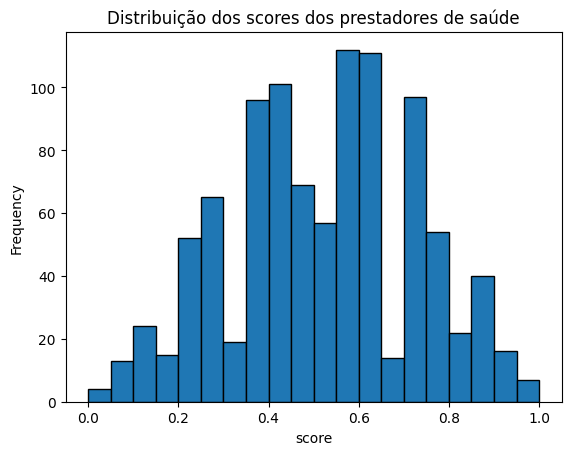

In [12]:




def plot_dist(sample,title,xlab):
    plt.hist(sample, bins=20, edgecolor='black')
    plt.xlabel(xlab)
    plt.ylabel('Frequency')
    plt.title(title)
    title = title.replace(' ','_')
    plt.savefig(f'{title}.png')
    plt.show()
    
plot = plot_dist(score['score'], title= 'Distribuição dos scores dos prestadores de saúde',xlab='score')
